In [61]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import time

from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

https://www.kaggle.com/c/siim-isic-melanoma-classification

Skin cancer is the most prevalent type of cancer. Melanoma, specifically, is responsible for 75% of skin cancer deaths, despite being the least common skin cancer. The American Cancer Society estimates over 100,000 new melanoma cases will be diagnosed in 2020. It's also expected that almost 7,000 people will die from the disease. As with other cancers, early and accurate detection—potentially aided by data science—can make treatment more effective.

Currently, dermatologists evaluate every one of a patient's moles to identify outlier lesions or “ugly ducklings” that are most likely to be melanoma. Existing AI approaches have not adequately considered this clinical frame of reference. Dermatologists could enhance their diagnostic accuracy if detection algorithms take into account “contextual” images within the same patient to determine which images represent a melanoma. If successful, classifiers would be more accurate and could better support dermatological clinic work.

As the leading healthcare organization for informatics in medical imaging, the Society for Imaging Informatics in Medicine (SIIM)'s mission is to advance medical imaging informatics through education, research, and innovation in a multi-disciplinary community. SIIM is joined by the International Skin Imaging Collaboration (ISIC), an international effort to improve melanoma diagnosis. The ISIC Archive contains the largest publicly available collection of quality-controlled dermoscopic images of skin lesions.

In this competition, you’ll identify melanoma in images of skin lesions. In particular, you’ll use images within the same patient and determine which are likely to represent a melanoma. Using patient-level contextual information may help the development of image analysis tools, which could better support clinical dermatologists.

Melanoma is a deadly disease, but if caught early, most melanomas can be cured with minor surgery. Image analysis tools that automate the diagnosis of melanoma will improve dermatologists' diagnostic accuracy. Better detection of melanoma has the opportunity to positively impact millions of people.

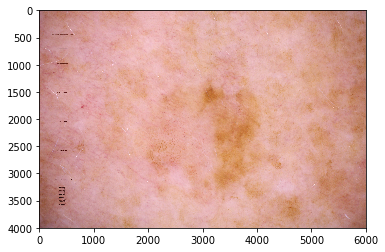

In [15]:
from PIL import Image
img = Image.open('data/jpeg/train/ISIC_0149568.jpg')
plt.imshow(img)

In [16]:
#metadados de treino
train = pd.read_csv('data/train.csv')
train.head(3)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0


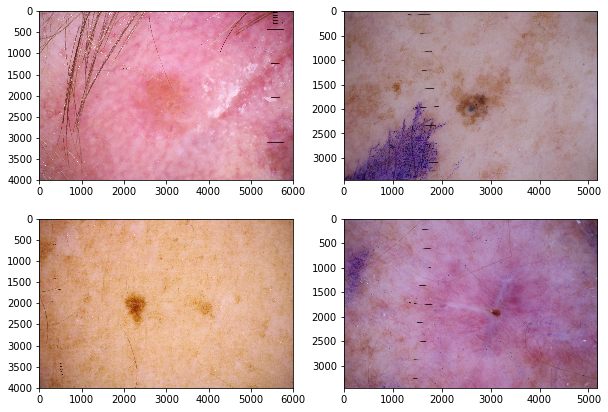

In [17]:
#plotar exemplos

malignant = train[train['target']==1]['image_name'].values[10:12]
benign = train[train['target']==0]['image_name'].values[0:2]

plt.figure(figsize=(10, 7))
base = 'data/jpeg/train/'
end = '.jpg'

#plt.suptitle('Exemplos de lesões benignas (esquerda) e malignas (direita)')

img = Image.open(base + benign[0] + end)
plt.subplot(221)
plt.imshow(img)

img = Image.open(base + malignant[0] + end)
plt.subplot(222)
plt.imshow(img)

img = Image.open(base + benign[1] + end)
plt.subplot(223)
plt.imshow(img)

img = Image.open(base + malignant[1] + end)
plt.subplot(224)
plt.imshow(img)

plt.show()

# IMAGE PRE-PROCESSING
1. RGB to Grayscale
2. Reshape (32x32)
3. Flatten (1D vector)

In [3]:
def preProcess(file,width,height):
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    dsize = (width, height)
    # resize image
    rescaled = cv2.resize(gray, dsize)
    flat = rescaled.flatten()
    return flat

In [5]:
# Cria um array com as imagens na forma de vetores 1D
X = []
image_name = []
scale = 1./128
dir_path = 'data/jpeg/train/'
decimal = int(len(os.listdir(dir_path))/10)

for i,f in enumerate(os.listdir(dir_path)):
    if(i%decimal==0):
        print(str((i/decimal)*10) + '%')
    file_path = dir_path + f
    #print(file_path)
    image_name.append(f.replace('.jpg',''))
    img_vector = preProcess(file_path,32,32)
    X.append(img_vector)
X = np.concatenate(X, axis=0).reshape(len(X), len(X[0]))
with open('X_32x32.npy', 'wb') as f:
    np.save(f,X)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


In [15]:
# criar vetor de rótulos associando o nome dos arquivos das imagens ao rótulo no dataset de treino
y = []
for img in image_name:
    yi = train[train['image_name']==img]['target'].values[0]
    y.append(yi)
    
with open('y_32x32.npy', 'wb') as f:
    np.save(f,y)

# SHALLOW MLP

In [2]:
#MLP shallow para classificação binária
class Shallow_MLP():
    
    def __init__(self,Nx,Nh,seed = 42):
        ''' 
        Inicializa a rede com o número Nx neurônios de entrada (número de atributos), 
        número Nh de neurônios da camada oculta 
        '''
        np.random.seed(seed)
        
        self.W = np.random.randn(Nh,Nx)*np.sqrt(1/Nx) 
        b_h = np.ones((Nh,1))*0.01
        self.W = np.concatenate((self.W,b_h),axis=1)
        
        self.M = np.random.randn(1,Nh)*np.sqrt(1/Nx)
        b_o = np.zeros((1,1))
        self.M = np.concatenate((self.M,b_o),axis=1)

        
    #funções de ativação e derivadas
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))
    
    def d_sigmoid(self,z):
        sig = self.sigmoid(z)
        return sig * (1 - sig)

    def relu(self,z):
        return np.maximum(0,z)
    
    def d_relu(self,z):
        return np.where(z >= 0, 1, 0)
    
    def feedfoward(self,x):
        #coloca o 1 do bias na última coluna
        x = x.reshape(1,x.shape[0])
        
        x = np.concatenate((x,np.ones((1,1))),axis=1)
        #soma ponderada na camada oculta
        u = self.W @ x.T
        #saída da função de ativação da camada oculta
        z = self.relu(u)
        z = np.concatenate((z,np.ones((1,1))),axis=0)        
        #soma ponderada na camada de saída
        r = self.M @ z
        #saída da função de ativação da camada de saída
        o = self.sigmoid(r)
        return o
    
    def predict(self,X):
        y_pred = []
        y_prob = []
        for x in X:
            prob = self.feedfoward(x)[0][0]
            if prob > 0.5:
                y_hat = 1
            else:
                y_hat = 0                
            y_pred.append(y_hat)
            y_prob.append(prob)
            
        return y_pred, y_prob
    
    #acurácia
    def score(self,X,y):
        y_pred, prob = self.predict(X)
        return float(sum(y_pred == y)) / float(len(y_test))  
                
    def backpropagation(self,x,y,alpha):
        #feedfoward
        x = x.reshape(1,x.shape[0])
        x = np.concatenate((x,np.ones((1,1))),axis=1)
        #soma ponderada na camada oculta
        u = self.W @ x.T
        #saída da função de ativação da camada oculta
        z = self.relu(u)
        z = np.concatenate((z,np.ones((1,1))),axis=0)        
        #soma ponderada na camada de saída
        r = self.M @ z
        #saída da função de ativação da camada de saída
        o = self.sigmoid(r)       
        
        #volta o erro e atualiza os pesos
        error = y-o
        delta = error * self.d_sigmoid(r)
        zeta = self.d_relu(u) * (self.M[:,0:-1].T @ delta)
        delta_M = delta @ z.T
        delta_W = zeta @ x
        return delta_M, delta_W
        
    def minibatch_backpropagation(self,X,y,alpha,lambda_l2):
        delta_M = 0
        delta_W = 0
        
        for i,x in enumerate(X):
            dM, dW = self.backpropagation(x,y[i],alpha)
            delta_M += dM
            delta_W = dW
        
        delta_M = delta_M/len(X)
        delta_W = delta_W/len(X)
        
        self.updateWeights(delta_M,delta_W,alpha,lambda_l2)
        
        
    def updateWeights(self, delta_M, delta_W, alpha, lambda_l2):
        #atualização dos pesos com regularização L2
        self.M = self.M + alpha * delta_M - alpha*lambda_l2*self.M 
        self.W = self.W + alpha * delta_W - alpha*lambda_l2*delta_W
        
    #SGD com minibatch
    def fit(self, X, y, alpha, epochs, minibatch_size, validation = False, lambda_l2 = 0, X_val = None, y_val = None):
        loss = []
        val_loss = []
        epoch_i = 0
        first_run = True
        
        while epoch_i < epochs:
            
            if first_run:
                t0 = time.time()
            

            #shuffle
            indices = np.random.permutation(X.shape[0])
            X = X[indices]
            y = y[indices]
            
            #minibatch
            for i in range(0, X.shape[0], minibatch_size):

                y_pred, y_prob = self.predict(X)
                loss_i = metrics.log_loss(y,y_prob)
                loss.append(loss_i)
                
                if validation == True:
                    y_pred, y_prob = self.predict(X_val)
                    loss_i = metrics.log_loss(y_val,y_prob)
                    val_loss.append(loss_i)                    
                
                X_train_mini = X[i:i + minibatch_size]
                y_train_mini = y[i:i + minibatch_size]
                self.minibatch_backpropagation(X_train_mini, y_train_mini, alpha, lambda_l2)
                
                epoch_i += 1
                
                if first_run:
                    t1 = time.time()
                    t = t1-t0
                    t = t/60
                    total = t*epochs
                    print('Tempo de execução da primeira época (min): %0.2f' % t)
                    print('Previsão de tempo total de execução: %0.2f' % total)
                    first_run = False
                    
                if epoch_i > epochs:
                    break
                    
        if validation == True:
            return loss, val_loss
        else:
            return loss
        

# K-NEAREST NEIGHBOORS

In [3]:
class KNNClassifier():
    #inicialize com dados de treino, saídas desejadas, quantidade K de vizinhos e a métrica de distância
    #opções de métricas: euclidean, mahalanobis 
    def __init__(self,X_train,y_train, K , dist_metric = 'euclidean'):
        
        self.X_train = X_train
        self.y_train = y_train
        self.K = K   
        self.dist_metric = dist_metric
        
        if dist_metric == 'mahalanobis':
            cov = np.cov(X_train)
            self.inv_covmat = sp.linalg.inv(cov)
        
    def euclidian(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))
    
    def manhattan(self, a, b):
        return np.sqrt(np.sum((a - b), axis=1))
    
    def chebyshev(self, a, b):
        return np.max(np.absolute(a - b), axis=1)
    
    def mahalanobis(self, a, b):        
        left_term = np.dot((a-b).T, self.inv_covmat)
        right_term = (a - b)
        mahal = np.dot(left_term,right_term)
        mahal = np.sqrt(mahal)
        return mahal

        
    def get_distance(self, a, b):
        if self.dist_metric == 'euclidean':
            return self.euclidian(a,b)
        
        elif self.dist_metric == 'mahalanobis':
            return self.mahalanobis(a,b)
        
        elif self.dist_metric == 'chebyshev':
            return self.chebyshev(a,b)
        
        elif self.dist_metric == 'manhattan':
            return self.manhattan(a,b)
        
    def kneighbors(self, X_test, return_distance=False):

        dist = []
        neigh_ind = []
        
        distances = [self.get_distance(x_test, self.X_train) for x_test in X_test]

        for row in distances:
            #enumera distancias
            enum_neigh = enumerate(row)
            #ordena distâncias e seleciona as K menores
            sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:self.K]
            #seleciona os índices dos K vizinhos mais próximos
            ind_list = [tup[0] for tup in sorted_neigh]
            #seleciona as distâncias dos K vizinhos mais próximos
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        #retorna as as distâncias para debug e os índices
        if return_distance:
            return np.array(dist), np.array(neigh_ind)
        
        #retorna apenas os índices
        return np.array(neigh_ind)
        
    
    def predict(self, X_test):        
        neighbors = self.kneighbors(X_test)
        #alteração para prever um valor contínuo (dividindo a quantidade de vizinhos de cada classe pelo K)
        #y_pred = np.array([np.argmax(np.bincount(y_train[neighbor].astype(int))) for neighbor in neighbors])
        prob_classes = [np.bincount(self.y_train[neighbor].astype(int))/self.K for neighbor in neighbors]
        y_pred = []
        prob_pos = []
        for bc in prob_classes:
            y_pred.append(np.argmax(bc))
            prob_pos.append(bc[0])
        prob_pos = [1 - p for p in prob_pos]
        return y_pred, prob_pos
    
    def score(self, X_test, y_test):
        y_pred, prob = self.predict(X_test)
        return float(sum(y_pred == y_test)) / float(len(y_test))


# LOAD PRE-PROCESSED DATA

In [4]:
X = np.load('X_32x32.npy')
print(X.shape)
y = np.load('y_32x32.npy')
print(y.shape)

(33126, 1024)
(33126,)


# UNDERSAMPLING

In [5]:
print('shape das imagens: ', X.shape)
y = y.reshape(y.shape[0],1)
print('shape dos rótulos: ', y.shape)
#concatena

data = np.concatenate((X,y),axis=1)
print('shape do array de imagens concatenados com rótulos: ', data.shape)

#separa em padrões positivos e negativos
pos_mask = data[:,-1] == 1 
pos = data[pos_mask,:]
neg_mask = data[:,-1] == 0 
neg = data[neg_mask,:]
print('shape dos padrões positivos: ', pos.shape)
print('shape dos padrões negativos: ', neg.shape)

#seleciona uma amostra aleatória de padrões negativos para igualar com a classe negativa (mais abundante)
np.random.seed(42)
idx = np.random.randint(neg.shape[0], size=pos.shape[0])
sampled = neg[idx,:]
#concatena a amostra de padrões negativos com os padrões positivos
data_sampled = np.concatenate((pos,sampled),axis=0)
print('shape do novo array de dados balanceados com rótulos: ', data_sampled.shape)
#divide em dados e rótulos (X,y)
X_sub = data_sampled[:,0:-1]
print('shape do novo array de dados balanceados: ', X_sub.shape)
y_sub = data_sampled[:,-1]
print('shape do novo array de rótulos balanceados: ', y_sub.shape)

shape das imagens:  (33126, 1024)
shape dos rótulos:  (33126, 1)
shape do array de imagens concatenados com rótulos:  (33126, 1025)
shape dos padrões positivos:  (584, 1025)
shape dos padrões negativos:  (32542, 1025)
shape do novo array de dados balanceados com rótulos:  (1168, 1025)
shape do novo array de dados balanceados:  (1168, 1024)
shape do novo array de rótulos balanceados:  (1168,)


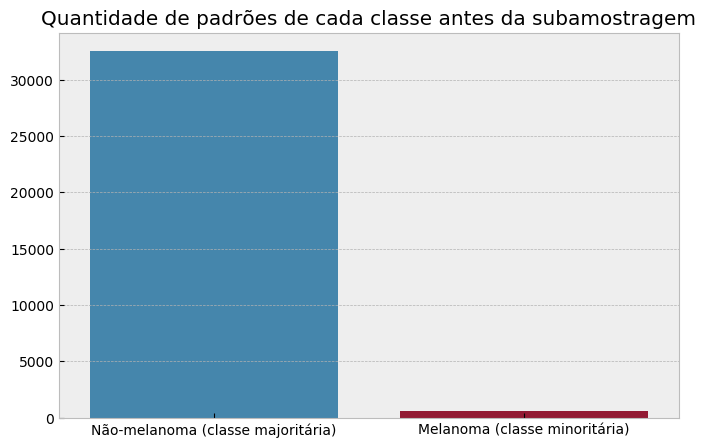

In [76]:
x = ['Não-melanoma (classe majoritária)', 'Melanoma (classe minoritária)']
y1 = [len(neg),len(pos)]
plt.figure(figsize=(8,5))
plt.title("Quantidade de padrões de cada classe antes da subamostragem")
sns.barplot(x,y1)

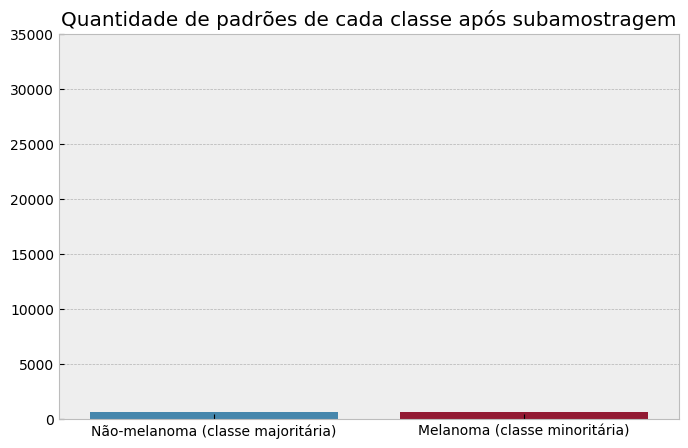

In [77]:
x = ['Não-melanoma (classe majoritária)', 'Melanoma (classe minoritária)']
y1 = [len(sampled),len(pos)]
plt.figure(figsize=(8,5))
#plt.yticks(ticks = [0,5000,10000,15000,20000,25000,3000])
#plt.yticks(np.arange(0, 35000, step=5000))
plt.ylim(0, 35000)
plt.title("Quantidade de padrões de cada classe após subamostragem")
sns.barplot(x,y1)
plt.show()

# TRAIN AND VALIDATION

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_sub, y_sub, test_size=0.1, random_state=42, stratify = y_sub)

#normalização
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)
X_train = (X_train - mu ) / sigma
X_val = (X_val - mu ) / sigma

print(X_train.shape)
print(X_val.shape)

(1051, 1024)
(117, 1024)


### VALIDATION MLP

Tempo de execução da primeira época (min): 0.00
Previsão de tempo total de execução: 9.50


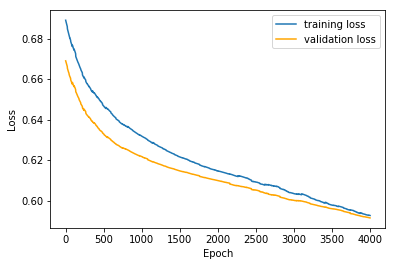

In [26]:
a = 0.001
nh = 200
e = 4000
l2 = 0.01

# validação mlp chutando o balde de neurônios
mlp = Shallow_MLP(X_train.shape[1],nh)
loss, val_loss = mlp.fit(X_train,y_train, alpha = a, lambda_l2 = l2, 
                         epochs = e, validation = True, minibatch_size = 50, 
                         X_val = X_val, y_val = y_val)

plt.plot(loss, label = 'training loss')
plt.plot(val_loss, color='orange', label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

accuracy:  0.6837606837606838
              precision    recall  f1-score   support

           0       0.81      0.49      0.61        59
           1       0.63      0.88      0.73        58

   micro avg       0.68      0.68      0.68       117
   macro avg       0.72      0.69      0.67       117
weighted avg       0.72      0.68      0.67       117

[[29 30]
 [ 7 51]]
0.8065458796025716


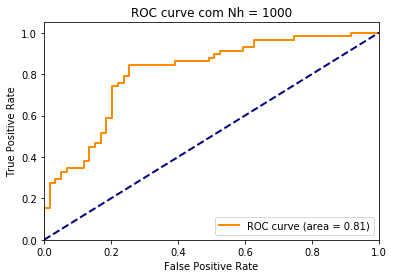

In [25]:
y_pred, prob = mlp.predict(X_val)
fpr, tpr, thresholds = metrics.roc_curve(y_val, prob, pos_label= 1)
print('accuracy: ', metrics.accuracy_score(y_val, y_pred))
print(metrics.classification_report(y_val, y_pred))
print(metrics.confusion_matrix(y_val, y_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_val, prob, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
#plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve com Nh = 1000')
plt.legend(loc="lower right")
plt.show()

### RANDOM SEARCH MLP

In [47]:
s = np.random.uniform(1,100)
b = int(s)
b

10

In [49]:
hyperparams = []
results = []
n_iter = 15
best_auc = 0

for i in range(n_iter):
    print(str(i+1) + '/' + str(n_iter))
    
    #alpha
    s = np.random.uniform(-5,-1)
    a = 10**s
    
    #lambda
    s = np.random.uniform(-5,-1)
    l = 10**s
    
    #neuronios na camada oculta
    s = np.random.uniform(2,20)
    nh = int(100*s)
    
    #epocas
    s = np.random.uniform(5,20)
    e = int(100*s)
    
    s = np.random.uniform(1,100)
    b = int(s)
    
    hyperparams.append([a, l, nh, e, b])
    
    print('training: ')
    print(hyperparams[i])
    
    
    mlp = Shallow_MLP(X_train.shape[1],nh)
    loss, val_loss = mlp.fit(X_train ,y_train, alpha = a, lambda_l2 = l, 
                         epochs = e, validation = True, minibatch_size = b, 
                         X_val = X_val, y_val = y_val)
    
    y_pred, prob = mlp.predict(X_val)
    fpr, tpr, thresholds = metrics.roc_curve(y_val, prob, pos_label= 1)
    
    roc_auc = metrics.auc(fpr, tpr)
    acc = metrics.accuracy_score(y_val, y_pred)
    
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_loss = loss
        best_val = val_loss
    
    results.append((acc,roc_auc))    
    hyperparams.append([a, l, nh, e, b])

val_data = list(zip(results,hyperparams))    
val_data = sorted(val_data, key=lambda tup: tup[0],reverse = True)
val_data 

1/15
training: 
[0.07418604285666672, 0.0015555627433596802, 962, 1352, 58]
Tempo de execução da primeira época (min): 0.02
Previsão de tempo total de execução: 21.94
2/15
training: 
[0.07418604285666672, 0.0015555627433596802, 962, 1352, 58]
Tempo de execução da primeira época (min): 0.02
Previsão de tempo total de execução: 37.46
3/15
training: 
[0.0016797672886560565, 0.014873627057294867, 1078, 1718, 15]
Tempo de execução da primeira época (min): 0.01
Previsão de tempo total de execução: 3.48
4/15
training: 
[0.0016797672886560565, 0.014873627057294867, 1078, 1718, 15]
Tempo de execução da primeira época (min): 0.01
Previsão de tempo total de execução: 24.30
5/15
training: 
[0.0001903598644355298, 0.002528498177797511, 500, 688, 76]
Tempo de execução da primeira época (min): 0.02
Previsão de tempo total de execução: 29.03
6/15
training: 
[0.0001903598644355298, 0.002528498177797511, 500, 688, 76]
Tempo de execução da primeira época (min): 0.00
Previsão de tempo total de execução: 1

[((0.7692307692307693, 0.8433664523670368),
  [0.07418604285666672, 0.0015555627433596802, 962, 1352, 58]),
 ((0.7350427350427351, 0.8310929281122151),
  [0.0021081287043859006, 0.0011890213204127907, 1187, 1248, 70]),
 ((0.7264957264957265, 0.7995324371712449),
  [1.0185792794726785e-05, 0.06544687097985451, 917, 1009, 68]),
 ((0.7094017094017094, 0.7776154295733488),
  [0.07418604285666672, 0.0015555627433596802, 962, 1352, 58]),
 ((0.7008547008547008, 0.793103448275862),
  [0.0001903598644355298, 0.002528498177797511, 500, 688, 76]),
 ((0.6923076923076923, 0.8012857977790765),
  [0.0003019920825453856, 0.04731033353481319, 676, 1970, 1]),
 ((0.6923076923076923, 0.7703097603740502),
  [0.003001831968359737, 0.004842623281432852, 1511, 1713, 82]),
 ((0.6410256410256411, 0.7209234365867914),
  [0.0016797672886560565, 0.014873627057294867, 1078, 1718, 15]),
 ((0.6410256410256411, 0.7185856224430158),
  [0.0001903598644355298, 0.002528498177797511, 500, 688, 76]),
 ((0.6410256410256411, 

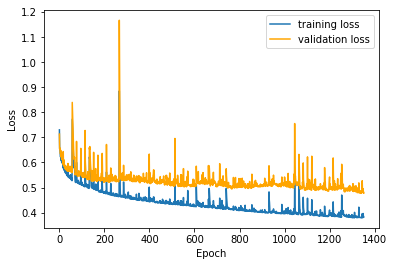

In [50]:
plt.plot(best_loss, label = 'training loss')
plt.plot(best_val, color='orange', label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

In [57]:
val_data = sorted(val_data, key=lambda tup: tup[0][1],reverse = True)
val_data

[((0.7692307692307693, 0.8433664523670368),
  [0.07418604285666672, 0.0015555627433596802, 962, 1352, 58]),
 ((0.7350427350427351, 0.8310929281122151),
  [0.0021081287043859006, 0.0011890213204127907, 1187, 1248, 70]),
 ((0.6923076923076923, 0.8012857977790765),
  [0.0003019920825453856, 0.04731033353481319, 676, 1970, 1]),
 ((0.7264957264957265, 0.7995324371712449),
  [1.0185792794726785e-05, 0.06544687097985451, 917, 1009, 68]),
 ((0.7008547008547008, 0.793103448275862),
  [0.0001903598644355298, 0.002528498177797511, 500, 688, 76]),
 ((0.7094017094017094, 0.7776154295733488),
  [0.07418604285666672, 0.0015555627433596802, 962, 1352, 58]),
 ((0.6923076923076923, 0.7703097603740502),
  [0.003001831968359737, 0.004842623281432852, 1511, 1713, 82]),
 ((0.6410256410256411, 0.7209234365867914),
  [0.0016797672886560565, 0.014873627057294867, 1078, 1718, 15]),
 ((0.6410256410256411, 0.7185856224430158),
  [0.0001903598644355298, 0.002528498177797511, 500, 688, 76]),
 ((0.6410256410256411, 

In [75]:
val_data = sorted(val_data, key=lambda tup: tup[0],reverse = True)

best_hyperparams = val_data[0][1]       

a = best_hyperparams[0]
l2 = best_hyperparams[1]
nh = best_hyperparams[2]
e = best_hyperparams[3]
m = best_hyperparams[4]

best_hyperparams

[0.07418604285666672, 0.0015555627433596802, 962, 1352, 58]

### GRID SEARCH / KNN

In [48]:
print(X_train.shape)
print(X_val.shape)

Ks = [1,5,9,15,19,25,29,33,35]
Ds = ['euclidean','manhattan','chebyshev']
results = []
hyperparams = []

for k in Ks:
    for d in Ds:
        clf = KNNClassifier(X_train, y_train, K=k, dist_metric = d)
        y_pred, prob = clf.predict(X_val)

        fpr, tpr, thresholds = metrics.roc_curve(y_val, prob, pos_label = 1)
        roc_auc = metrics.auc(fpr, tpr)
        acc = metrics.accuracy_score(y_val, y_pred)

        results.append((acc,roc_auc))
        hyperparams.append((k,d))
        
val_data = list(zip(results,hyperparams))        

val_data = sorted(val_data, key=lambda tup: tup[0][1],reverse = True)
val_data 

(1051, 1024)
(117, 1024)


/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


[((0.7350427350427351, 0.8392752776154295), (9, 'euclidean')),
 ((0.7350427350427351, 0.8300701344243133), (15, 'euclidean')),
 ((0.7521367521367521, 0.8277323202805377), (35, 'euclidean')),
 ((0.7606837606837606, 0.8271478667445938), (33, 'euclidean')),
 ((0.7606837606837606, 0.8267095265926359), (29, 'euclidean')),
 ((0.7350427350427351, 0.826417299824664), (19, 'euclidean')),
 ((0.7435897435897436, 0.8243717124488603), (25, 'euclidean')),
 ((0.6495726495726496, 0.7526300409117475), (5, 'euclidean')),
 ((0.6410256410256411, 0.7295441262419637), (19, 'chebyshev')),
 ((0.6495726495726496, 0.7273524254821742), (15, 'chebyshev')),
 ((0.6324786324786325, 0.7253068381063705), (5, 'chebyshev')),
 ((0.7094017094017094, 0.7090882524839276), (1, 'chebyshev')),
 ((0.5982905982905983, 0.701782583284629), (25, 'chebyshev')),
 ((0.6324786324786325, 0.700759789596727), (9, 'chebyshev')),
 ((0.6410256410256411, 0.6998831092928112), (33, 'chebyshev')),
 ((0.6239316239316239, 0.6984219754529515), (29,

In [50]:
val_data = sorted(val_data, key=lambda tup: tup[0][1],reverse = True)
val_data 

[((0.7350427350427351, 0.8392752776154295), (9, 'euclidean')),
 ((0.7350427350427351, 0.8300701344243133), (15, 'euclidean')),
 ((0.7521367521367521, 0.8277323202805377), (35, 'euclidean')),
 ((0.7606837606837606, 0.8271478667445938), (33, 'euclidean')),
 ((0.7606837606837606, 0.8267095265926359), (29, 'euclidean')),
 ((0.7350427350427351, 0.826417299824664), (19, 'euclidean')),
 ((0.7435897435897436, 0.8243717124488603), (25, 'euclidean')),
 ((0.6495726495726496, 0.7526300409117475), (5, 'euclidean')),
 ((0.6410256410256411, 0.7295441262419637), (19, 'chebyshev')),
 ((0.6495726495726496, 0.7273524254821742), (15, 'chebyshev')),
 ((0.6324786324786325, 0.7253068381063705), (5, 'chebyshev')),
 ((0.7094017094017094, 0.7090882524839276), (1, 'chebyshev')),
 ((0.5982905982905983, 0.701782583284629), (25, 'chebyshev')),
 ((0.6324786324786325, 0.700759789596727), (9, 'chebyshev')),
 ((0.6410256410256411, 0.6998831092928112), (33, 'chebyshev')),
 ((0.6239316239316239, 0.6984219754529515), (29,

In [52]:
best_hyperparams = val_data[0][1]       
best_K = best_hyperparams[0]
best_K

9

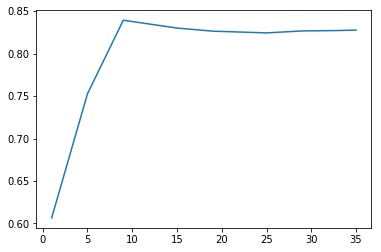

In [38]:
val_data = sorted(val_data, key=lambda tup: tup[1],reverse = True)
auc = [tup[0][1] for tup in val_data]
Ks = [tup[1] for tup in val_data]
plt.plot(Ks,auc)

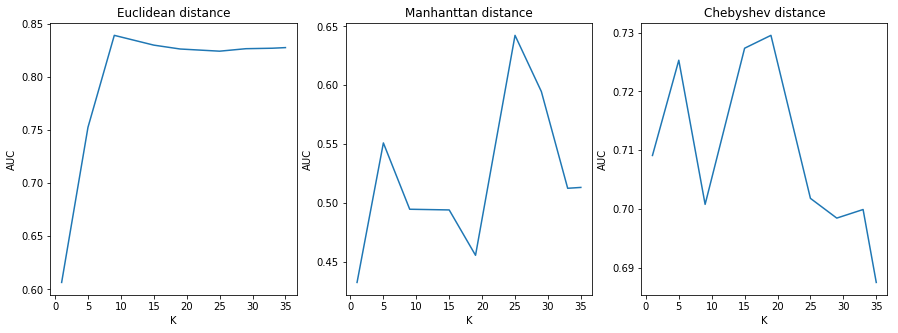

In [69]:
val_data = sorted(val_data, key=lambda tup: tup[1], reverse = False)
#[f(x) if condition else g(x) for x in sequence]
cheby_auc = [c[0][1] if c[1][1] == 'chebyshev' else None for c in val_data]
cheby_auc = [i for i in cheby_auc if i]

man_auc = [c[0][1] if c[1][1] == 'manhattan' else None for c in val_data]
man_auc = [i for i in man_auc if i]

euc_auc = [c[0][1] if c[1][1] == 'euclidean' else None for c in val_data]
euc_auc = [i for i in euc_auc if i]

plt.figure(figsize=(15, 5))


plt.subplot(131)
plt.plot(Ks,euc_auc)
plt.title('Euclidean distance')
plt.xlabel('K')
plt.ylabel('AUC')

plt.subplot(132)
plt.plot(Ks,man_auc)
plt.title('Manhanttan distance')
plt.xlabel('K')
plt.ylabel('AUC')

plt.subplot(133)
plt.plot(Ks,cheby_auc)
plt.title('Chebyshev distance')
plt.xlabel('K')
plt.ylabel('AUC')

plt.show()

# KNN VALIDATION

In [39]:
KNN_clf = KNNClassifier(X_train, y_train, K=best_K)
y_pred, prob = KNN_clf.predict(X_val)

In [40]:
print('accuracy: ', metrics.accuracy_score(y_val, y_pred))
print(metrics.classification_report(y_val, y_pred))
metrics.confusion_matrix(y_val, y_pred)

accuracy:  0.7350427350427351
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        59
           1       0.76      0.67      0.72        58

   micro avg       0.74      0.74      0.74       117
   macro avg       0.74      0.73      0.73       117
weighted avg       0.74      0.74      0.73       117



array([[47, 12],
       [19, 39]])

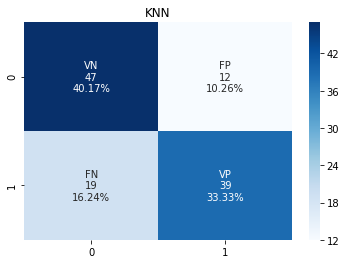

In [62]:
cf_matrix = np.array([[47, 12],
                  [19, 39]])

group_names = ['VN','FP','FN','VP']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.title('KNN')
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

0.8392752776154295


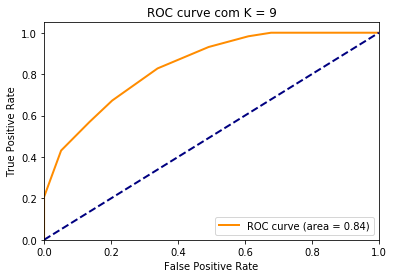

In [41]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, prob, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
#plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve com K = ' + str(best_K))
plt.legend(loc="lower right")
plt.show()

# MLP TRAIN-VAL

Tempo de execução da primeira época (min): 0.02
Previsão de tempo total de execução: 24.01


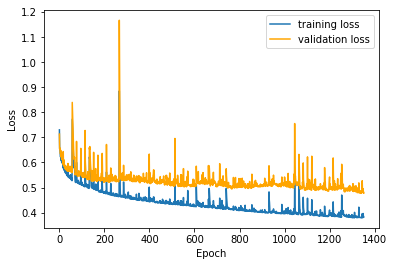

In [65]:
mlp = Shallow_MLP(X_train.shape[1],nh)
loss, val_loss = mlp.fit(X_train,y_train, alpha = a, lambda_l2 = l2, 
                         epochs = e, validation = True, minibatch_size = m, 
                         X_val = X_val, y_val = y_val)

plt.plot(loss, label = 'training loss')
plt.plot(val_loss, color='orange', label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()


In [66]:
y_pred, y_prob = mlp.predict(X_val)
print('accuracy: ', metrics.accuracy_score(y_val, y_pred))
print(metrics.classification_report(y_val, y_pred))
metrics.confusion_matrix(y_val, y_pred)

accuracy:  0.7692307692307693
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        59
           1       0.76      0.78      0.77        58

   micro avg       0.77      0.77      0.77       117
   macro avg       0.77      0.77      0.77       117
weighted avg       0.77      0.77      0.77       117



array([[45, 14],
       [13, 45]])

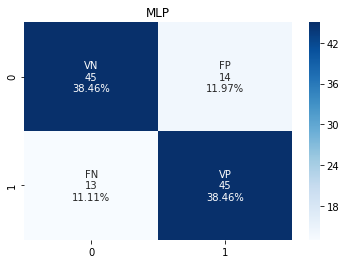

In [67]:
cf_matrix = metrics.confusion_matrix(y_val, y_pred)

group_names = ['VN','FP','FN','VP']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.title('MLP')
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

0.8433664523670368


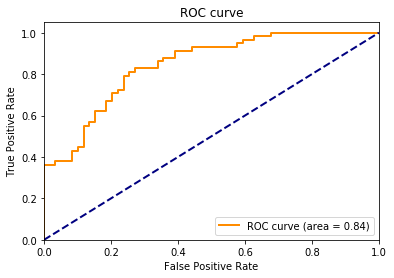

In [68]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_prob, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
#plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# TRAIN MODEL WITH ALL UNDERSAMPLED DATA AND MAKE SUBMISSION TO KAGGLE

In [69]:
X_test = np.load('X_test_32x32.npy')
import pickle
infile = open("image_name_test.p",'rb')
image_name = pickle.load(infile)
infile.close()
image_name = [n.replace('.jpg','') for n in image_name]

In [70]:
#TREINO COM TODOS OS DADOS
#normalização
mu = np.mean(X_sub, 0)
sigma = np.std(X_sub, 0)
X_sub = (X_sub - mu ) / sigma
X_test = (X_test - mu ) / sigma

Tempo de execução da primeira época (min): 0.01
Previsão de tempo total de execução: 19.07


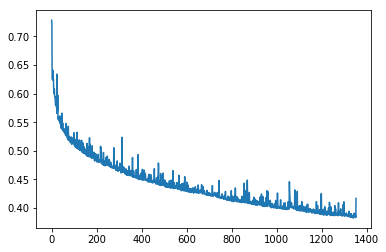

In [71]:
mlp = Shallow_MLP(X_sub.shape[1],nh)
loss = mlp.fit(X_sub, y_sub, alpha = a, epochs = e, lambda_l2 = l2, minibatch_size = 50)
plt.plot(loss)

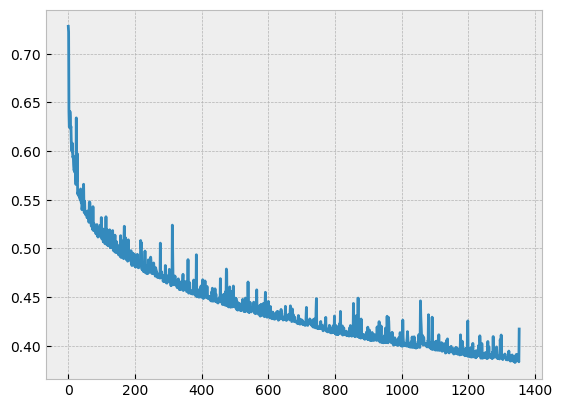

In [78]:
plt.plot(loss)

In [72]:
y_pred, y_prob = mlp.predict(X_test)
submission_mlp = pd.DataFrame({'image_name':image_name,'target':y_prob})

In [73]:
submission_mlp.to_csv('data/submission_mlp.csv',index = False)

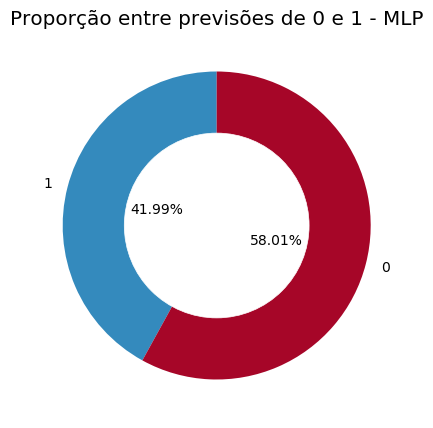

In [74]:
# proporção entre mensagens de mídia e de texto
plt.style.use('default')
plt.style.use('bmh')
plt.figure(figsize=(5, 5))
plt.title('Proporção entre previsões de 0 e 1 - MLP')
x = [len(submission_mlp[submission_mlp['target']>0.5]),len(submission_mlp[submission_mlp['target']<=0.5])]
names = ['1','0']
my_circle=plt.Circle( (0,0), 0.6, color='white')
plt.pie(x, labels=names,autopct='%1.2f%%',startangle=90, pctdistance=0.4)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [10]:
KNN_clf = KNNClassifier(X_sub, y_sub, K = 9)
y_pred, prob = KNN_clf.predict(X_test)
submission_knn = pd.DataFrame({'image_name':image_name,'target':prob})

In [11]:
submission_knn = pd.DataFrame({'image_name':image_name,'target':prob})
submission_knn['image_name'] = [name.replace('.jpg','') for name in submission_knn['image_name']]
submission_knn.to_csv('data/submission_9nn.csv',index = False)

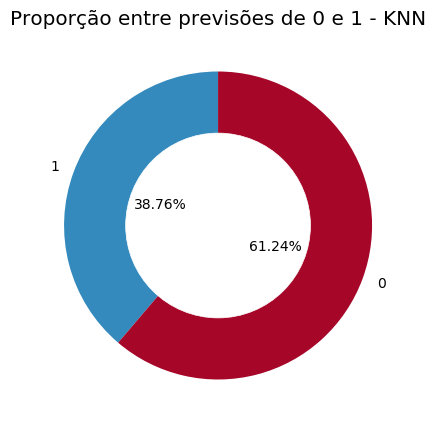

In [12]:
# proporção entre mensagens de mídia e de texto
plt.style.use('default')
plt.style.use('bmh')
plt.figure(figsize=(5, 5))
plt.title('Proporção entre previsões de 0 e 1 - KNN')
x = [len(submission_knn[submission_knn['target']>0.5]),len(submission_knn[submission_knn['target']<=0.5])]
names = ['1','0']
my_circle=plt.Circle( (0,0), 0.6, color='white')
plt.pie(x, labels=names,autopct='%1.2f%%',startangle=90, pctdistance=0.4)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# RESULTS
* shape = 32x32
* grayscale
* random undersampling
* z-score normalization

## KNN

* K = 9
* distance = euclidean
* ***score***: 0.7240

## MLP
* 1 layer
* Nh = 962
* alpha = 0.0741
* lambda = 0.0015
* theta1 = relu
* theta2 = sigmoid
* minibatch size = 58
* epochs = 1352
* ***score***: 0.7894
